# Load gripper data and obj data

In [1]:
import os
import re
import pandas as pd
import numpy as np
from glob import glob

def load_gripper_and_obj_trajectories_full(base_dir, triangulation = 'leastereo'):
    '''
    This function look for the demos in base_dir, and load the ndi file and marker_3d file. 
    
    Parameters
    ----------
    base_dir: string
        The path to the folder where all the demonstrations are saved.
    triangulation: string
        'leastereo' or 'dlc3d', which corresponds to which triangulation method is used to get the
        
    Returns
    -------
    gripper_traj: dict
        A dictionary whose keys are the demonstraions' ids. 
        The values are the dataframes of the corersponding
        demonstration's gripper trajectory data in ndi reference frame.
    obj_traj: dict
        A dictionary whose keys are the demonstraions' ids. The values are the dataframes of the corersponding
        demonstration's objects' pose trajectories in camera reference frame.
    '''
    all_files = os.listdir(base_dir)
    r = re.compile("^[0-9]+$")
    demos = list(filter(r.match, all_files)) 
    gripper_trajs = {}
    markers_trajs = {}
    for demo in demos:
        demo_dir = os.path.join(base_dir, demo)
        root, dirs, files = next(os.walk(demo_dir))
        ndi_file = glob(os.path.join(demo_dir, '*NDI*'))[0]
        markers_traj_file = os.path.join(demo_dir, triangulation, 'markers_trajectory_3d.h5')

        # Open NDI file and extract the parts corresponding to the queried action
        df_temp1 = pd.read_csv(ndi_file)
        gripper_trajs[demo] = df_temp1
        
        df_temp2 = pd.read_hdf(markers_traj_file)
        markers_trajs[demo] = df_temp2.droplevel('scorer', axis = 1)
    return gripper_trajs, markers_trajs


def get_gripper_and_obj_trajectories_for_ith_action(dfs_ndi, dfs_camera, basedir, i = 0):
    '''
    Given the gripper trajs and markers_trajs loaded, this function will go in basedir and look for the Servo file
    to chunk the trajs and output the ith action's trajs.
    
    Parameters
    ---------
    dfs_ndi: dict
        A directory that contains the full gripper trajectories for different demos.
    dfs_camera: dict
        A directory that contains the full object markers trajectories for different demos.
    basedir: string
        The path to the directory that contains the demos
    i: int
        The index of the action
    '''
    gripper_trajs = {}
    markers_trajs = {}
    for demo in dfs_ndi:
        df_ndi = dfs_ndi[demo]
        df_camera = dfs_camera[demo]
        demo_dir = os.path.join(base_dir, demo)
        root, dirs, files = next(os.walk(demo_dir))
        if demo == 'transformations' or demo == '364642':
            continue
        servo_file = glob(os.path.join(demo_dir, '*Servo*'))[0]
        with open(servo_file, 'r') as f:
            lines = f.readlines()
            t_start = float(lines[1 + i].split(',')[0])
            t_end = float(lines[2 + i].split(',')[0])
        duration = t_end - t_start
        idx_start = df_ndi['Time'].sub(t_start).abs().idxmin()
        idx_end = df_ndi['Time'].sub(t_end).abs().idxmin()
        df_gripper = df_ndi.copy()[idx_start: idx_end]
        # Set the time to start from 0
        df_gripper.loc[:, 'Time'] = df_gripper.loc[:, 'Time'] - df_gripper.loc[:, 'Time'].iloc[0]
        gripper_trajs[demo] = df_gripper
        
        idx_start_obj = int(len(df_camera) * idx_start / len(df_ndi))
        idx_end_obj = int(len(df_camera) * idx_end / len(df_ndi))
        df_markers = df_camera[idx_start_obj: idx_end_obj].reset_index(drop=True)
        df_markers.loc[:,'Time'] = np.arange(len(df_markers))/len(df_markers)*duration
        markers_trajs[demo] = df_markers
    return gripper_trajs, markers_trajs
    
base_dir = '../Process_data/postprocessed/2022-05-26'

triangulation = 'dlc3d'
gripper_trajs_in_ndi_full, obj_trajs_in_camera_full = load_gripper_and_obj_trajectories_full(base_dir, triangulation = triangulation )
gripper_trajs_in_ndi, obj_trajs_in_camera = get_gripper_and_obj_trajectories_for_ith_action(gripper_trajs_in_ndi_full, obj_trajs_in_camera_full,basedir = base_dir)

# Plot original gripper trajs in ndi reference frame

<IPython.core.display.Javascript object>


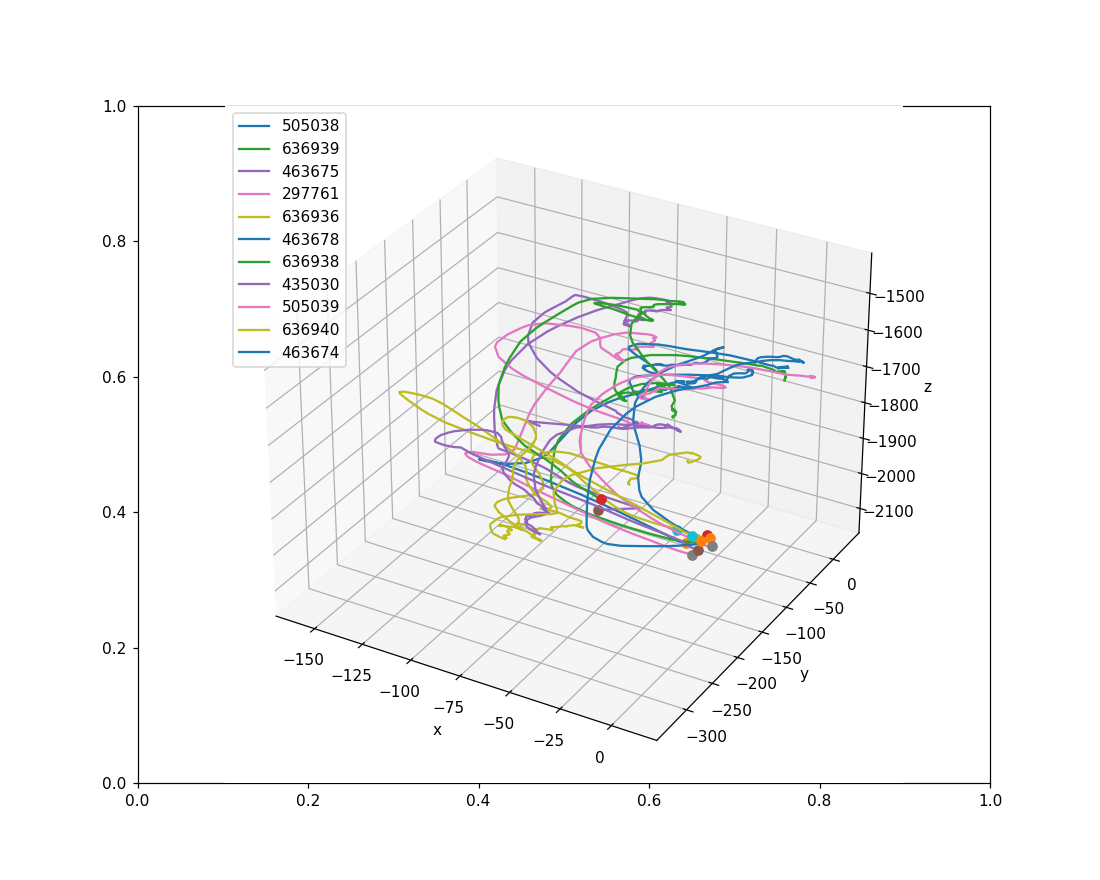

In [2]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots(1,1, figsize = (10,8))
ax = plt.axes(projection='3d')
bad_demos = []
for demo in gripper_trajs_in_ndi:
    if demo in bad_demos:
        continue
    gripper_traj = gripper_trajs_in_ndi[demo].loc[:,['x', 'y', 'z']].to_numpy()
    gripper_in_obj = gripper_traj
    
    ax.plot(gripper_in_obj[:, 0], gripper_in_obj[:, 1], gripper_in_obj[:, 2], label = f'{demo}')
    ax.plot(gripper_in_obj[0, 0], gripper_in_obj[0, 1], gripper_in_obj[0, 2], 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Apply DTW

In [3]:
from dtw_util import *

demos = [demo for demo in gripper_trajs_in_ndi.keys()]
num_demos = len(demos)
trajs_len = []
normalized_demos = {}
for demo in demos:
    df = gripper_trajs_in_ndi[demo]
    time_diff = df['Time'].diff(1)
    temp = ((np.sqrt(np.square(df.loc[:, ['x','y','z']].diff(1)).sum(axis=1))))/time_diff
    gripper_trajs_in_ndi[demo]['Speed'] = np.array(temp)
    gripper_trajs_in_ndi[demo].dropna(inplace=True)
    trajs_len.append(len(gripper_trajs_in_ndi[demo]))
# get demos with median duration
median_len_ind = trajs_len.index(int(np.median(trajs_len)))
median_len_demo = demos[median_len_ind]

ref_demo_speed = gripper_trajs_in_ndi[median_len_demo]['Speed'].to_numpy()
ref_demo_traj = gripper_trajs_in_ndi[median_len_demo].loc[:, gripper_trajs_in_ndi[median_len_demo].columns != 'Speed']

min_cost_demos = {}
for demo in demos:
    test_demo_speed = gripper_trajs_in_ndi[demo]['Speed'].to_numpy()
    test_demo_traj = gripper_trajs_in_ndi[demo].loc[:, gripper_trajs_in_ndi[demo].columns != 'Speed'].copy().to_numpy()
    match_indices, min_cost = dynamic_time_warp(ref_demo_speed, test_demo_speed)
    match_indices = np.array(match_indices)
    min_cost_demos[demo] = min_cost
    new_demo = np.zeros(ref_demo_traj.shape)
    for match in match_indices:
        new_demo[match[0]] = test_demo_traj[match[1]]
    new_demo[-1] = test_demo_traj[-1]
    new_demo[0] = test_demo_traj[0]
    normalized_demo = ref_demo_traj.copy()
    normalized_demo.at[:, :] = new_demo
    normalized_demos[demo] = normalized_demo

<IPython.core.display.Javascript object>


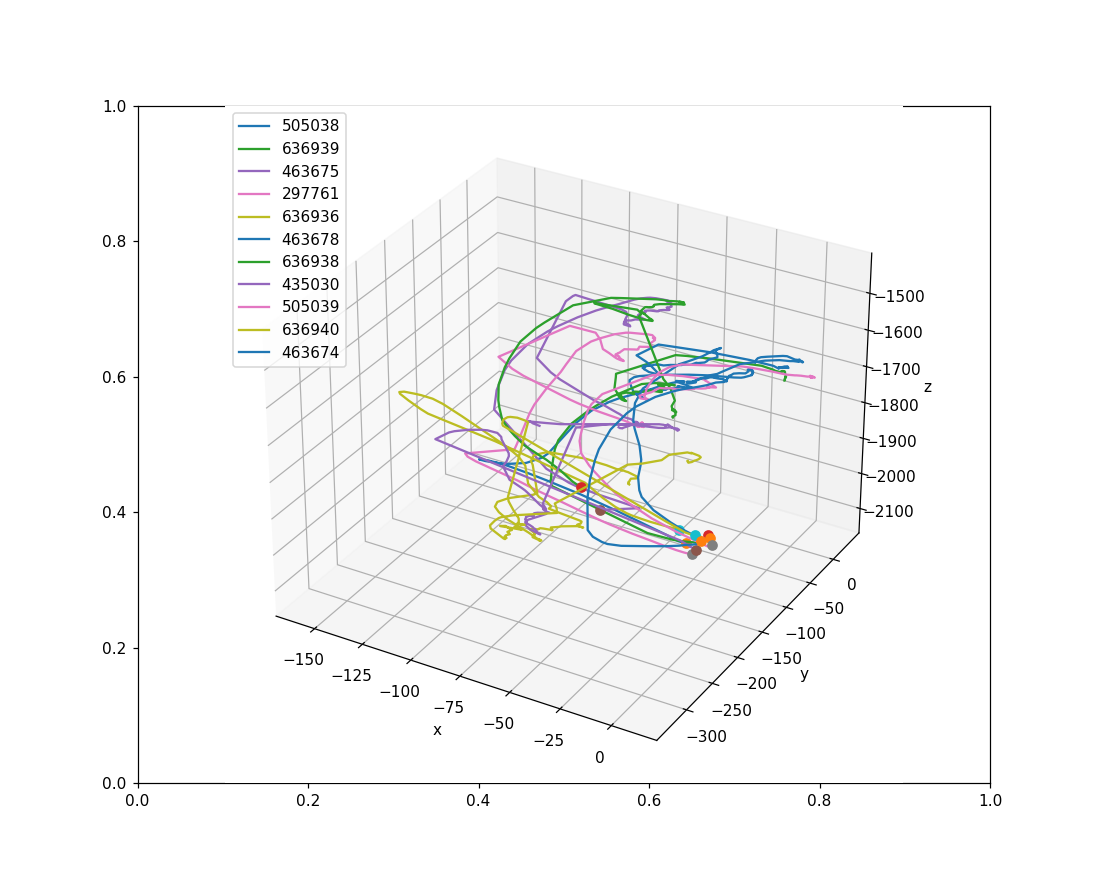

In [4]:
from matplotlib import pyplot as plt
%matplotlib notebook
fig,ax = plt.subplots(1,1, figsize = (10,8))
ax = plt.axes(projection='3d')
for demo in normalized_demos:
    gripper_traj = normalized_demos[demo].loc[:,['x', 'y', 'z']].to_numpy()
    ax.plot(gripper_traj[:, 0], gripper_traj[:, 1], gripper_traj[:, 2], label = f'{demo}')
    ax.plot(gripper_traj[0, 0], gripper_traj[0, 1], gripper_traj[0, 2], 'o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()

# Convert gripper trajs from ndi to obj reference frame

In [5]:

import pickle
from itertools import combinations

def homogenous_transform(R,vect):

    '''
    :param R: 3x3 matrix
    :param vect: list x,y,z
    :return:Homogenous transformation 4x4 matrix using R and vect
    '''

    H = np.zeros((4,4))
    H[0:3,0:3] = R
    frame_displacement = vect + [1]
    D = np.array(frame_displacement)
    D.shape = (1,4)
    H[:,3] = D
    return H

def inverse_homogenous_transform(H):

    '''
    :param H: Homogenous Transform Matrix
    :return: Inverse Homegenous Transform Matrix
    '''


    R = H[0:3,0:3]
    origin = H[:-1,3]
    origin.shape = (3,1)

    R = R.T
    origin = -R.dot(origin)
    return homogenous_transform(R,list(origin.flatten()))

def rigid_transform_3D(A, B):
    assert A.shape == B.shape

    num_rows, num_cols = A.shape
    if num_rows != 3:
        raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

    num_rows, num_cols = B.shape
    if num_rows != 3:
        raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

    # find mean column wise
    centroid_A = np.mean(A, axis=1)
    centroid_B = np.mean(B, axis=1)

    # ensure centroids are 3x1
    centroid_A = centroid_A.reshape(-1, 1)
    centroid_B = centroid_B.reshape(-1, 1)

    # subtract mean
    Am = A - centroid_A
    Bm = B - centroid_B

    H = Am @ np.transpose(Bm)

    # sanity check
    #if linalg.matrix_rank(H) < 3:
    #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

    # find rotation
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

#     special reflection case
    if np.linalg.det(R) < 0:
#         print("det(R) < R, reflection detected!, correcting for it ...")
        Vt[2,:] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A + centroid_B

    return R, t

def get_HT_template_in_obj(template, obj_coord, camera_in_template):
    '''
    This function will align the object with template and output the homogeneous transformation 
    and the markers' average distance
    
    Parameters
    ----------
    template: dict
        The obj template that has the markers position in camera reference frame
    obj_coord: dict
        The dict that contains the marker's coordinates in camera reference frame for a frame of the video
    camera_in_template: np.array
        A 4 by 4 array that represents camera in the template's reference frame
        
    Returns
    -------
    template_in_obj: np.array
        A 4 by 4 homogeneous transformation that represents template in the object's reference frame
    dist: float
        The lowest average markers' distance after aligning object with the template
    
    '''
    idx = pd.IndexSlice
    points_template = []
    points_obj = []
    if not isinstance(obj_coord, dict):
        bps = obj_coord.index.get_level_values('bodyparts').unique()
        for bodypart in bps:
            df_bodypart = obj_coord.loc[bodypart]
            if not df_bodypart.isnull().values.any():
                points_template.append(template[bodypart])
                points_obj.append(df_bodypart.to_numpy())
    else:
        keys = obj_coord.keys()
        for bodypart in keys:
            df_bodypart = df[bodypart]
            if not df_bodypart.isnull().values.any():
                points_template.append(template[bodypart])
                points_obj.append(df_bodypart.to_numpy())
                
    points_template = np.array(points_template).T
    points_obj = np.array(points_obj).T
    
    points_template_in_template = camera_in_template @ homogenous_position(points_template)
    points_obj_in_template = camera_in_template @ homogenous_position(points_obj)
    rotmatrix, translation = rigid_transform_3D(points_obj_in_template[:3,:], points_template_in_template[:3,:])
    H = homogenous_transform(rotmatrix, list(translation.flatten()))
    
    points_obj_transformed = (H @ points_obj_in_template).T
    dists = []
    for i, point in enumerate(points_obj_transformed):
        point = point[:3]
        dist = np.linalg.norm(point[:3] - points_template_in_template[:-1,i])
        dists.append(dist)
    dist_average = np.mean(np.array(dists), axis=0)
#     print(f'distances : {dists}')
#     print(f'average distance: {dist_average}')
    return H, dist_average


def homogenous_position(vect):
    '''
    This function will make sure the coordinates in the right shape(4 by N) that could be multiplied by a
    homogeneous transformation(4 by 4).
    
    Parameters
    ----------
    vect: list or np.array
        A 3 by N array. x, y, z coordinates of the N points
        
    Return 
    ------
    A 4 by N array.
    '''
    temp = np.array(vect)
    if temp.ndim == 1:
        ones = np.ones(1)
        return np.r_[temp, ones].reshape(-1, 1)
    elif temp.ndim == 2:
        
        num_rows, num_cols = temp.shape
        if num_rows != 3:
            raise Exception(f"vect is not 3 * N, it is {num_rows}x{num_cols}")

        ones = np.ones(num_cols).reshape(1,-1)
        return np.r_[temp, ones]


def get_matched_marker_coords(obj_template, df_individual, camera_in_template, window_size, n_marker = 3):
    '''
    Search the first window_size rows of df_individual so that it matches the obj_template the best.
    
    Parameters
    ----------
    obj_template: dict
        The obj template that has the markers position in camera reference frame
    df_individual: Dataframe
        The Dataframe that contains the DLC + LEAstereo output for an individual
    camera_in_template: np.array
        A 4 by 4 array that represents camera in the template's reference frame
    window_size: int
        The first window_size rows that will be searched to find the best row
    n_marker: int
        The number of markers that will be used to align object with template.
        
    Returns
    -------
    template_in_obj: np.array
        A 4 by 4 homogeneous transformation that represents template in the object's reference frame
    dist: float
        The lowest average markers' distance after aligning object with the template
    
    '''
    dist = np.inf
    for i in range(window_size):
        marker_coords = df_individual.iloc[i]
        bps = marker_coords.index.get_level_values('bodyparts').unique()
        combs = combinations(bps, n_marker)
        for comb in combs:
            partial_marker_coords = marker_coords.loc[list(comb)]
            if partial_marker_coords.isnull().any():
                continue
            H, dist_average = get_HT_template_in_obj(obj_template, partial_marker_coords, camera_in_template)
            if dist_average < dist:
                dist = dist_average
                template_in_obj = H
    return template_in_obj, dist

individuals = ['teabag1', 'teabag2', 'cup', 'pitcher', 'tap']
bad_demos = ['463678', '636936', '636938', '463675']

'''
'463678', '636936': mislabeled teabag1
'636938', '463675': starting point far from other demos
'''
gripper_trajs_in_obj = {individual :{} for individual in individuals}
template_dir = f'/home/luke/Desktop/project/make_tea/Process_data/postprocessed/2022-05-26/transformations/{triangulation}'
with open(os.path.join(template_dir, 'obj_templates.pickle'), "rb") as f:
    obj_templates = pickle.load(f)
with open(os.path.join(template_dir, 'camera_to_ndi.pickle'), "rb") as f:
    camera_in_ndi = pickle.load(f)
with open(os.path.join(template_dir, 'ndi_to_camera.pickle'), "rb") as f:
    ndi_in_camera = pickle.load(f)

demos = [demo for demo in gripper_trajs_in_ndi]
obj_pos_in_ndi = {demo: {} for demo in demos}
window_size = 20

# trajs_to_model = gripper_trajs_in_ndi
trajs_to_model = normalized_demos
As = {}
bs = {}
for individual in individuals:
    As[individual] = {}
    bs[individual] = {}
    if 'teabag' in individual:
        obj = 'teabag'
    elif individual == 'global':
        for demo in gripper_trajs_in_ndi.keys():
            gripper_trajs_in_obj[individual][demo] = trajs_to_model[demo]
            obj_pos_in_ndi[demo][individual] = np.array([0,0,0])
        continue
    else:
        obj = individual
    obj_template = obj_templates[obj]
    rot_matrix = ndi_in_camera[:3,:3]

    markers = []
    for bp in obj_template:
        markers.append(obj_template[bp])
    markers = np.array(markers)
    center = np.mean(markers, axis=0)
    template_in_camera = homogenous_transform(rot_matrix, list(center))
    camera_in_template = inverse_homogenous_transform(template_in_camera)
    for demo in obj_trajs_in_camera:
        dists = {}
        df_individual = obj_trajs_in_camera_full[demo][individual]
        template_in_obj, dist = get_matched_marker_coords(obj_template, df_individual, camera_in_template, window_size)
        dists[demo] = dist
        if dist > 20:
            bad_demos.append(demo)
        if demo in bad_demos:
            continue
        gripper_traj = trajs_to_model[demo].loc[:,['x', 'y', 'z']].to_numpy()
        obj_in_template = inverse_homogenous_transform(template_in_obj)
#         obj_in_camera = template_in_camera @ obj_in_template
        obj_in_ndi = camera_in_ndi @ template_in_camera @ obj_in_template
        obj_in_ndi[:3, :3] = np.eye(3)
        obj_pos_in_ndi[demo][individual] = obj_in_ndi[:-1, 3]
        ndi_in_obj = inverse_homogenous_transform(obj_in_ndi)
        As[individual][demo] = ndi_in_obj[:3, :3]
        bs[individual][demo] = ndi_in_obj[:3, 3]
        
        gripper_in_obj = (ndi_in_obj @ homogenous_position(gripper_traj.T)).T[:,:-1]
        gripper_traj_in_obj = trajs_to_model[demo].copy()
        gripper_traj_in_obj[['x', 'y', 'z']] = gripper_in_obj
        gripper_trajs_in_obj[individual][demo] = gripper_traj_in_obj

# Plot trajs in obj frame

<IPython.core.display.Javascript object>


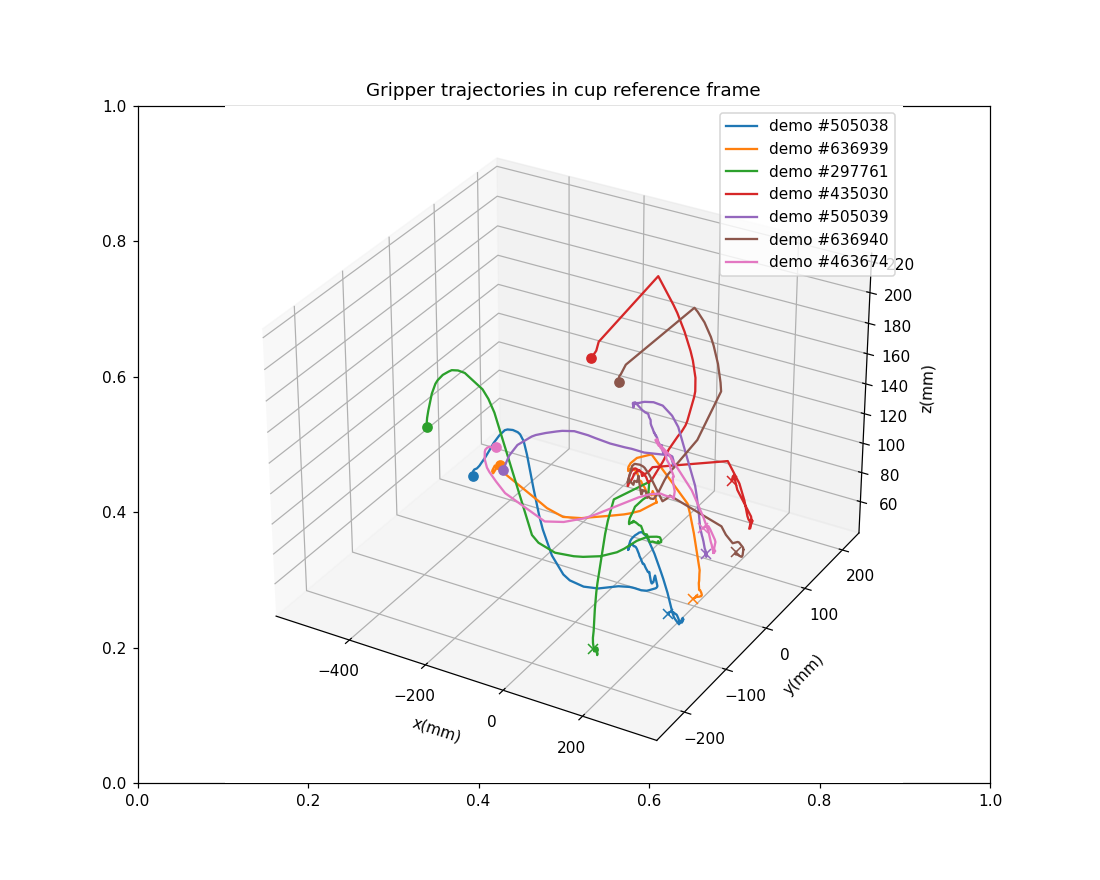

In [6]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook


fig,ax = plt.subplots(1,1, figsize = (10,8))

individual = 'cup'

data = gripper_trajs_in_obj
ax = plt.axes(projection='3d')
for demo in data[individual]:
    df = data[individual][demo]
    line = ax.plot(df.loc[:,'z'], df.loc[:,'y'], -df.loc[:,'x'], label = f'demo #{demo}');
    ax.plot(df.loc[:,'z'].iloc[0], df.loc[:,'y'].iloc[0], -df.loc[:,'x'].iloc[0],  'o', color = line[0].get_color())
    ax.plot(df.loc[:,'z'].iloc[-1], df.loc[:,'y'].iloc[-1], -df.loc[:,'x'].iloc[-1], 'x', color = line[0].get_color())
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    ax.set_title(f'Gripper trajectories in {individual} reference frame')
plt.legend()    
plt.show()

# Filter data

In [7]:
from scipy import ndimage
# A Gaussian filter is used to get the trajectories smoother so that it is easier to learn
gripper_trajs_in_obj_filtered = {individual :{} for individual in individuals}
sigma = 2
sigma = [sigma, 0]
for individual in individuals:
    for demo in gripper_trajs_in_obj[individual]:
        q = gripper_trajs_in_obj[individual][demo].loc[:, ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']]
        q_filtered = ndimage.gaussian_filter(q, sigma = sigma)
        temp = gripper_trajs_in_obj[individual][demo].copy()
        temp.loc[:, ['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']] = q_filtered
        gripper_trajs_in_obj_filtered[individual][demo] = temp
        

# Plot filtered trajectories with bad demos removed

<IPython.core.display.Javascript object>


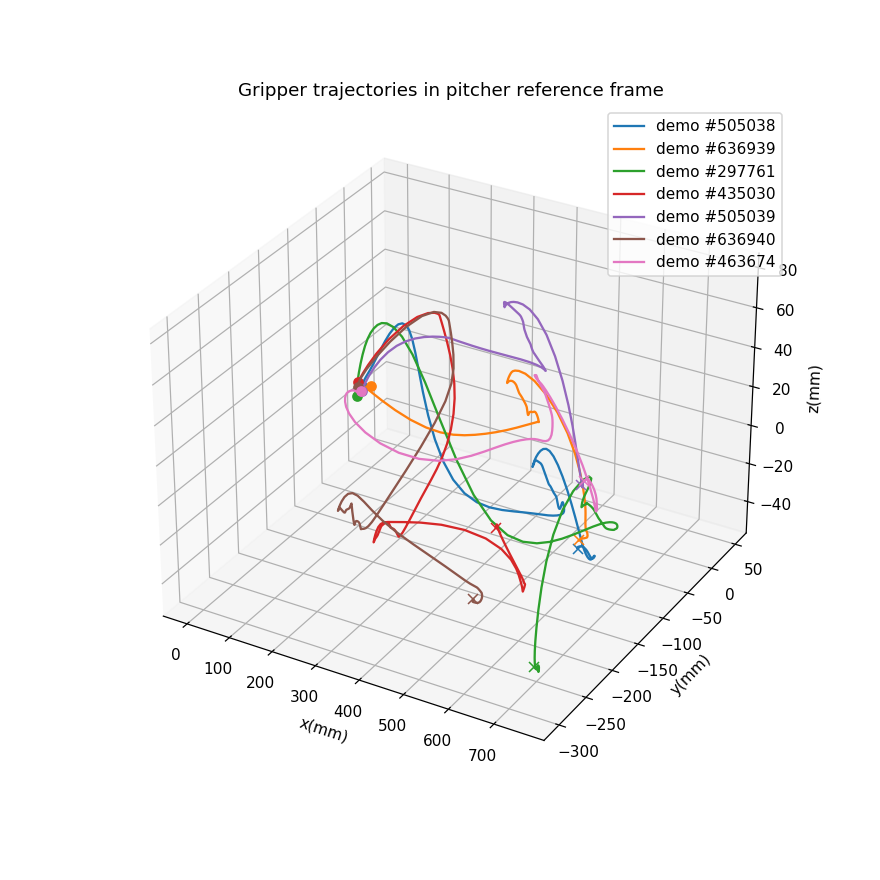

In [8]:
individual = 'pitcher'

'''
teabag1 is incorrectly labeld for demos: '505039', '463678'
something is wrong with tap: '636938'
something is wrong with pitcher: '463675'
'''
plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

data = gripper_trajs_in_obj_filtered
for demo in data[individual]:
    if demo in bad_demos:
        continue
    df = data[individual][demo]
    line = ax.plot(df.loc[:,'z'], df.loc[:,'y'], -df.loc[:,'x'], label = f'demo #{demo}');
    ax.plot(df.loc[:,'z'].iloc[0], df.loc[:,'y'].iloc[0], -df.loc[:,'x'].iloc[0],  'o', color = line[0].get_color())
    ax.plot(df.loc[:,'z'].iloc[-1], df.loc[:,'y'].iloc[-1], -df.loc[:,'x'].iloc[-1], 'x', color = line[0].get_color())
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    ax.set_title(f'Gripper trajectories in {individual} reference frame')
plt.legend()    
plt.show()

<IPython.core.display.Javascript object>


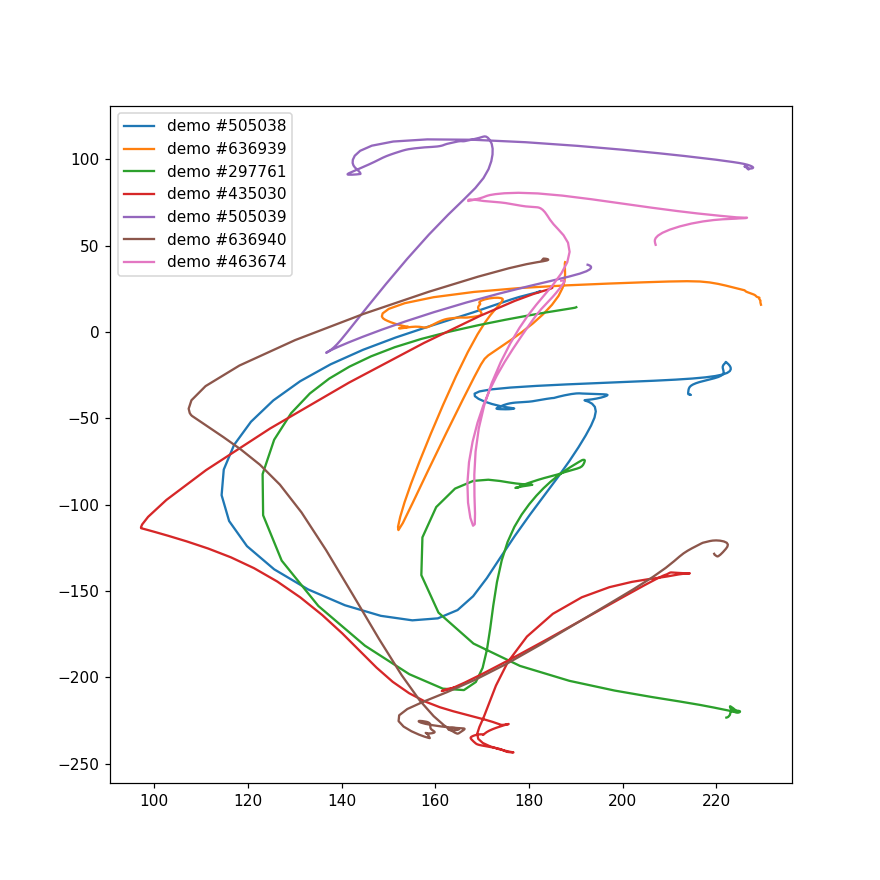

In [9]:
individual = 'tap'

'''
teabag1 is incorrectly labeld for demos: '505039', '463678'
something is wrong with tap: '636938'
something is wrong with pitcher: '463675'
'''
plt.figure(figsize = (8,8))

data = gripper_trajs_in_obj_filtered
for demo in data[individual]:
    if demo in bad_demos:
        continue
    df = data[individual][demo]
    line = plt.plot(df.loc[:,'x'], df.loc[:,'y'], label = f'demo #{demo}');
plt.legend()    
plt.show()

## Learning model

0.001
0.001
0.001
0.001


<IPython.core.display.Javascript object>


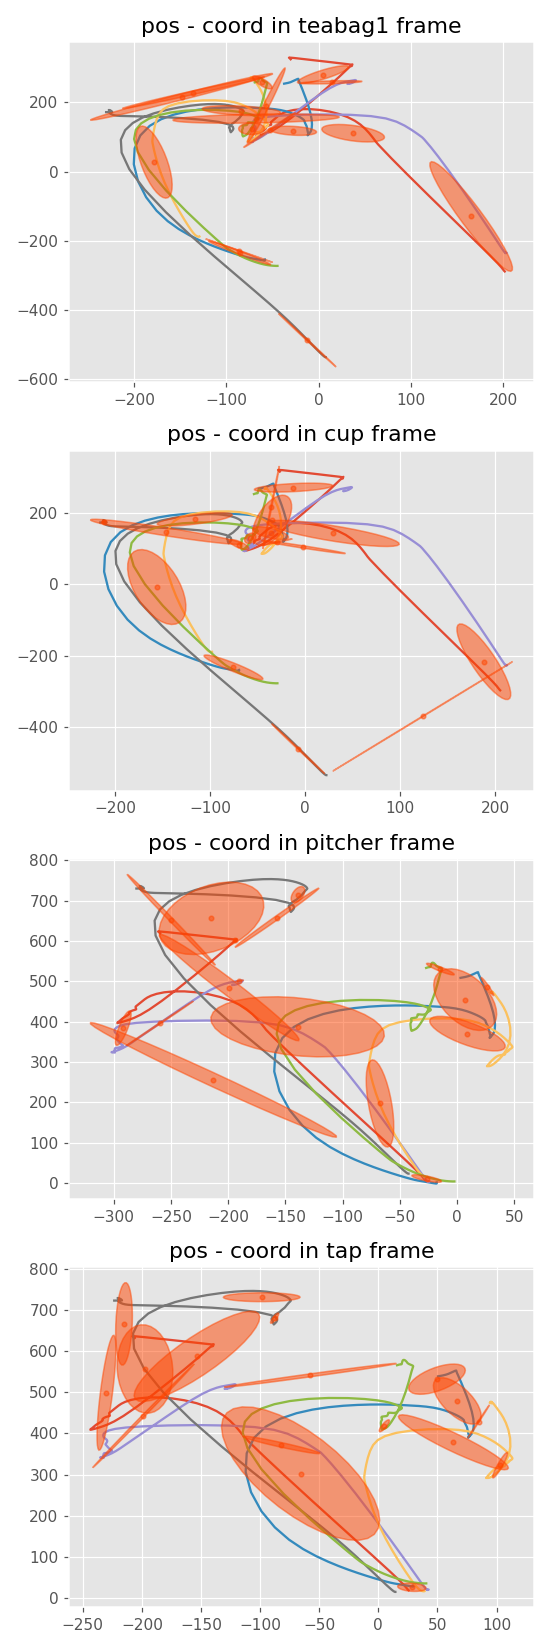

In [297]:
import random
import gmm
demos = [demo for demo in list(gripper_trajs_in_ndi.keys())if demo not in bad_demos]
train_demos = random.sample(demos, k = 6)
test_demo = [demo for demo in demos if demo not in train_demos and demo not in bad_demos][0]
demos_x_f = []
gmms = []
dims = ['Time', 'x', 'y', 'z']
individuals = [i for i in individuals if i != 'teabag2']
n_dim = len(dims)
for individual in individuals:
    temp = []
    for d in train_demos:
        data_demo = gripper_trajs_in_obj_filtered[individual][d][dims].to_numpy()
        temp.append(data_demo)
#         print(gripper_trajs_in_obj_filtered[individual][d][['Time', 'z', 'x', 'y']].to_numpy())
#         raise
    demos_x_f.append(np.array(temp))
    data = np.concatenate(temp)
    m = gmm.GMM(nb_states = 17, nb_dim = n_dim)
    m.init_hmm_kbins(temp)
#     m.em(data, reg=[1e-1] + [1.] * (n_dim - 1)) 
    m.em(data, reg=1e-3, maxiter = 1000) 
    gmms.append(m)
    
from plot import plot_gmm
fig, ax = plt.subplots(nrows=len(gmms))
fig.set_size_inches(5,15)

for j, individual in enumerate(individuals):
    # position plotting
    ax[j].set_title(f'pos - coord in {individual} frame')
    for k, p in enumerate(demos_x_f[j]):
        ax[j].plot(p[:,2], p[:,3])
    model = gmms[j]
    plot_gmm(model.mu[:, 2:4], model.sigma[:, 2:4, 2:4], ax=ax[j], color='orangered'); 
plt.tight_layout() 

## Transforming models in a global coordinate system and product

Here we transform all the models in separate coordinate systems in a global systems and compute a compromise between them, as they were multiple experts, giving there opinions. The compromise is computed with the product of Gaussian http://www.tina-vision.net/docs/memos/2003-003.pdf.

<IPython.core.display.Javascript object>


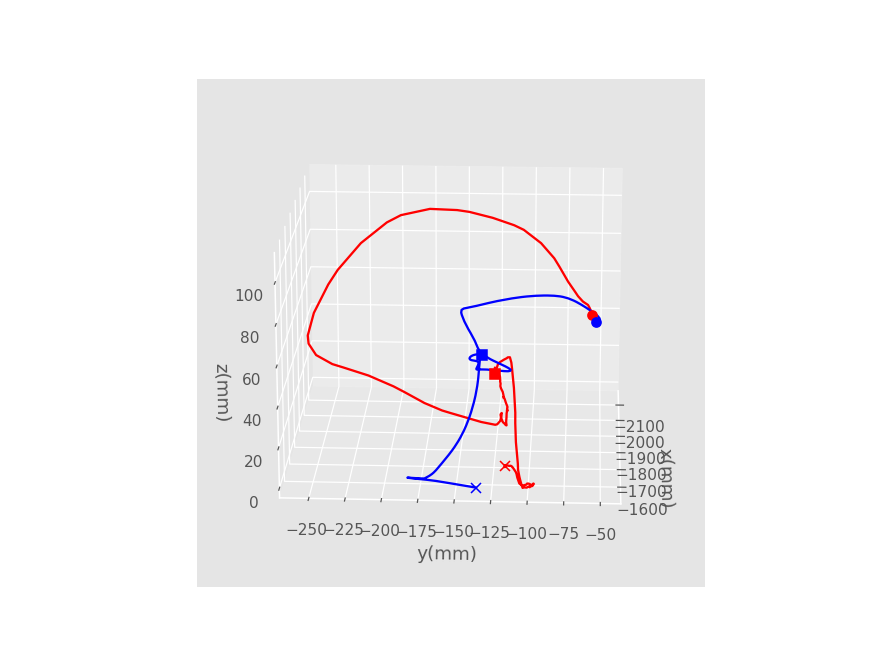

This distance at the start point is 29.70014547698402 mm
This distance at the middle point is 13.247369357255806 mm
This distance at the end point is 27.659099538358817 mm


In [298]:
# transformed model for coordinate system 1
t = gripper_trajs_in_obj_filtered[individual][test_demo]['Time'].to_numpy()

mus = []
sigmas = []
for i, model in enumerate(gmms):
    individual = individuals[i]
    mu, sigma = gmms[i].condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(1, 4))
    mu = mu @ As[individual][test_demo] - bs[individual][test_demo]
    mus.append(mu)
    sigmas.append(sigma)
# mu1, sigma1 = gmms[2].condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(1, 4))
# mu1 = mu1 @ As['cup'][test_demo] - bs['cup'][test_demo]
# # transformed model for coordinate system 2
# mu2, sigma2 = gmms[4].condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(1, 4))
# mu2 = mu2 @ As['tap'][test_demo] - bs['tap'][test_demo]

# # product 
# prod = mod1 * mod2
def get_mean_cov_hats(ref_means, ref_covs, min_len=None):
    sigma_hats, ref_pts = [], len(ref_means)
    if not min_len:
        min_len = min([len(r) for r in ref_means])
    # solve for global covariance
    for p in range(min_len):
        covs = [cov[p] for cov in ref_covs]
        inv_sum = np.linalg.inv(covs[0])
        for ref in range(1, ref_pts):
            inv_sum = inv_sum + np.linalg.inv(covs[ref])
        sigma_hat = np.linalg.inv(inv_sum)
        sigma_hats.append(sigma_hat)

    mean_hats = []
    for p in range(min_len):
        mean_w_sum = np.matmul(np.linalg.inv(ref_covs[0][p]), ref_means[0][p])
        for ref in range(1, ref_pts):
            mean_w_sum = mean_w_sum + np.matmul(np.linalg.inv(ref_covs[ref][p]), ref_means[ref][p])
        mean_hats.append(np.matmul(sigma_hats[p], mean_w_sum))
    return np.array(mean_hats), np.array(sigma_hats)

mu_hat, sigma_hat = get_mean_cov_hats(mus, sigmas)
ground_truth = normalized_demos[test_demo][['x', 'y', 'z']].to_numpy()
mid_ind = int(0.62 * len(mu_hat))
# fig, ax = plt.subplots()
# fig.set_size_inches((8, 8))
# # plot_gmm(mu_hat, sigma_hat, swap=True,ax=ax, dim=[0, 1], color='steelblue', alpha=0.3)
# ax.plot(mu_hat[:,0], mu_hat[:,1])
# ax.plot(ground_truth[:,0], ground_truth[:,1])
plt.figure(figsize = (8,6))
ax = plt.axes(projection='3d')
ax.plot(ground_truth[:,2], ground_truth[:,1], -ground_truth[:,0],'r', label = 'ground_truth')
ax.plot(mu_hat[:,2], mu_hat[:,1], -mu_hat[:,0], 'b', label = 'prediction')
ax.plot(ground_truth[0,2], ground_truth[0,1], -ground_truth[0,0],'ro', label = 'start')
ax.plot(ground_truth[mid_ind,2], ground_truth[mid_ind,1], -ground_truth[mid_ind,0],'rs', label = 'middle')
ax.plot(ground_truth[-1,2], ground_truth[-1,1], -ground_truth[-1,0],'rx', label = 'end')
ax.plot(mu_hat[0,2], mu_hat[0,1], -mu_hat[0,0],'bo', label = 'start')
ax.plot(mu_hat[mid_ind,2], mu_hat[mid_ind,1], -mu_hat[mid_ind,0],'bs', label = 'middle')
ax.plot(mu_hat[-1,2], mu_hat[-1,1], -mu_hat[-1,0],'bx', label = 'end')
ax.set_xlabel('x(mm)')
ax.set_ylabel('y(mm)')
ax.set_zlabel('z(mm)')
dist_mid = np.linalg.norm(ground_truth[mid_ind,:3] - mu_hat[mid_ind,:3])
dist_start = np.linalg.norm(ground_truth[0,:3] - mu_hat[0,:3])
dist_end = np.linalg.norm(ground_truth[-1,:3] - mu_hat[-1,:3])
print(f'This distance at the start point is {dist_start} mm')
print(f'This distance at the middle point is {dist_mid} mm')
print(f'This distance at the end point is {dist_end} mm')

    

In [299]:
test_demo

'505038'

In [206]:
# transformed model for coordinate system 1
mod1 = gmms[0].marginal_model(slice(1, 4)).lintrans(As['teabag1'][test_demo], -bs['teabag1'][test_demo])

# transformed model for coordinate system 2
mod2 = gmms[4].marginal_model(slice(1, 4)).lintrans(As['tap'][test_demo], -bs['tap'][test_demo])

# product 
prod = mod1 * mod2

<IPython.core.display.Javascript object>


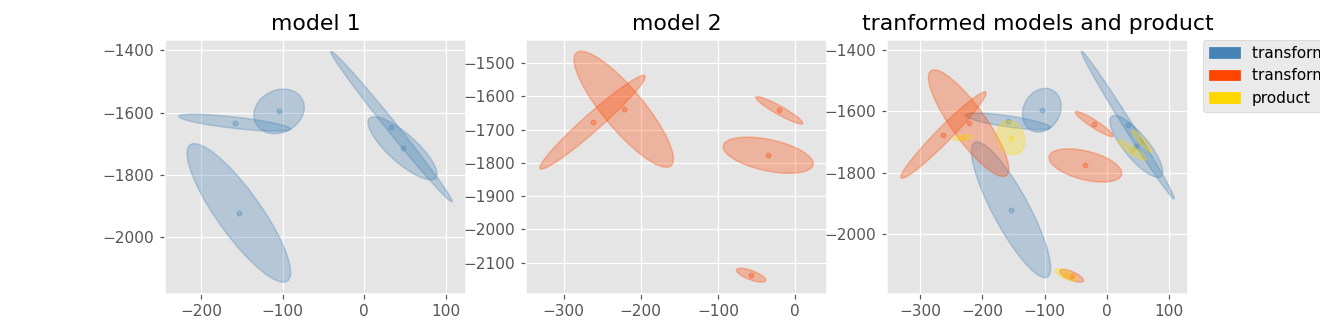

In [207]:
import matplotlib.patches as mpatches

fig, ax = plt.subplots(ncols=3)
fig.set_size_inches((12, 3))
# for a in ax: a.set_aspect('equal')

ax[0].set_title('model 1')
plot_gmm(mod1.mu, mod1.sigma, swap=True,ax=ax[0], dim=[1, 2], color='steelblue', alpha=0.3)
ax[1].set_title('model 2')
plot_gmm(mod2.mu, mod2.sigma, swap=True,ax=ax[1], dim=[1, 2], color='orangered', alpha=0.3)

ax[2].set_title('tranformed models and product')
plot_gmm(mod1.mu, mod1.sigma, swap=True,ax=ax[2], dim=[1, 2], color='steelblue', alpha=0.3)
plot_gmm(mod2.mu, mod2.sigma, swap=True,ax=ax[2], dim=[1, 2], color='orangered', alpha=0.3)
plot_gmm(prod.mu, prod.sigma, swap=True,ax=ax[2], dim=[1, 2], color='gold', alpha = 0.3)

patches = [mpatches.Patch(color='steelblue', label='transformed model 1'),
            mpatches.Patch(color='orangered', label='transformed model 2'),
            mpatches.Patch(color='gold', label='product')]

plt.legend(handles=patches,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [210]:
for i, model in enumerate(gmms):
    individual = individuals[i]
    if i == 0:
        prod = model.marginal_model(slice(1, 4)).lintrans(As[individual][test_demo].T, -bs[individual][test_demo])
    else:
        prod = prod * model.marginal_model(slice(1, 4)).lintrans(As[individual][test_demo].T, -bs[individual][test_demo])

<IPython.core.display.Javascript object>


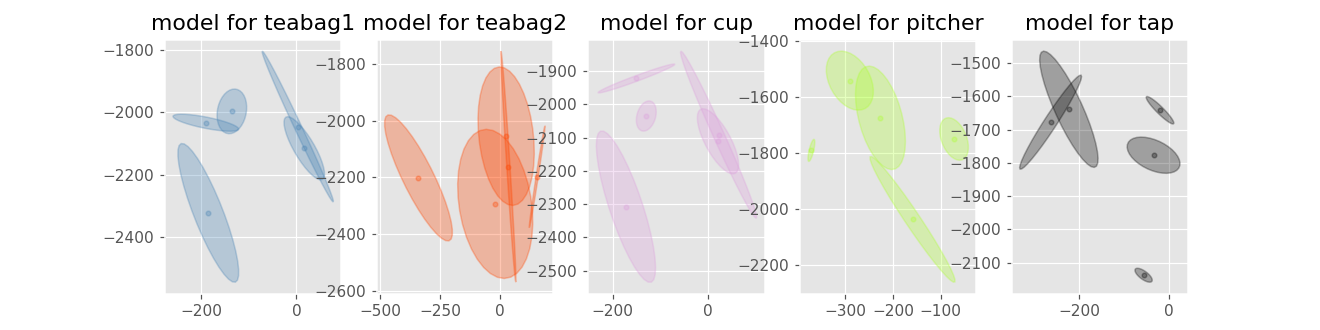

<IPython.core.display.Javascript object>


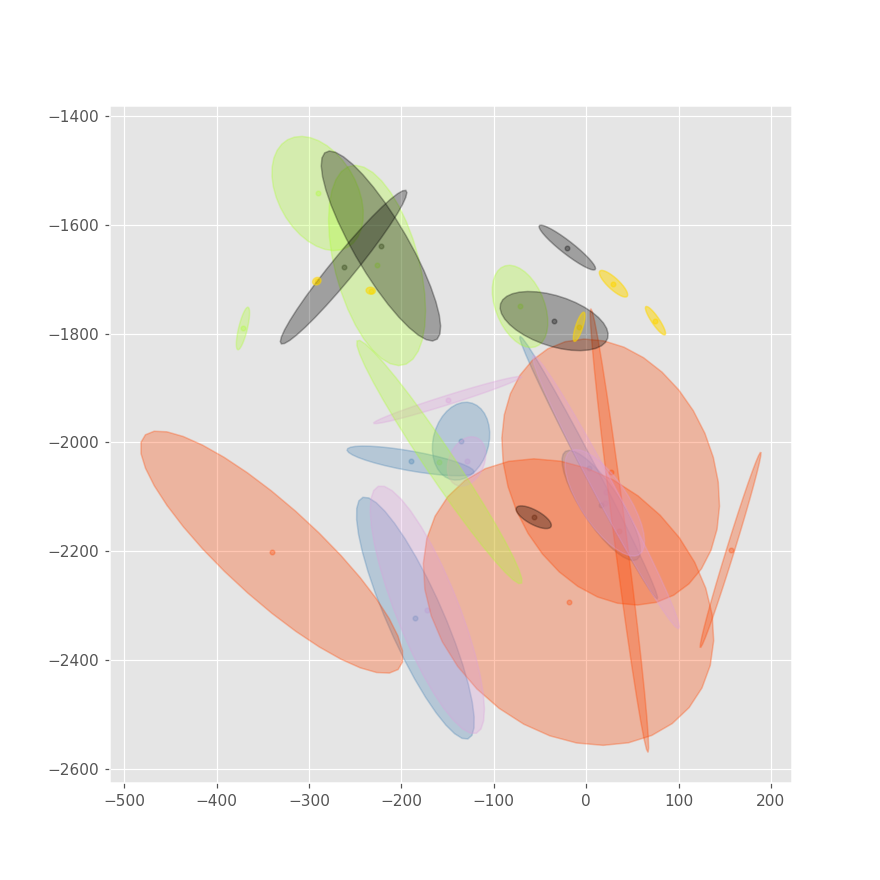

In [212]:
fig, ax = plt.subplots(ncols=len(individuals))
fig.set_size_inches((12, 3))
colors = ['steelblue', 'orangered', 'plum', 'greenyellow', 'black']
for i, a in enumerate(ax):
    model = gmms[i].marginal_model(slice(1, 4)).lintrans(As[individual][test_demo].T, -bs[individual][test_demo])
#     a.set_aspect('equal')
    ax[i].set_title(f'model for {individuals[i]}')
    plot_gmm(model.mu, model.sigma, swap=True,ax=ax[i], dim=[1, 2], color=colors[i], alpha=0.3)

fig, ax = plt.subplots(ncols=1)
fig.set_size_inches((8, 8))
for i,_ in enumerate(individuals):
    model = gmms[i].marginal_model(slice(1, 4)).lintrans(As[individual][test_demo].T, -bs[individual][test_demo])
    plot_gmm(model.mu, model.sigma, swap=True,ax=ax, dim=[1, 2], color=colors[i], alpha=0.3)
plot_gmm(prod.mu, prod.sigma, swap=True,ax=ax, dim=[1, 2], color='gold')

# Train ProbMPs

In [297]:
import random

sig = 0.035 # The standard deviation of the Gaussian functions
# Define the basis functions
full_basis = {
        'conf': [
                {"type": "sqexp", "nparams": 22, "conf": {"dim": 21}},
            {"type": "poly", "nparams": 0, "conf": {"order": 1}},
            {"type": "poly", "nparams": 0, "conf": {"order": 2}},
            {"type": "poly", "nparams": 0, "conf": {"order": 3}}
            ],
        'params': [np.log(sig),0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65
                   ,0.7,0.75,0.8,0.85,0.9,0.95,1]
        }

individuals = ['pitcher', 'teabag1', 'cup', 'tap', 'teabag2']
# Each individual will have its own promp model
promps = {individual : promp.FullProMP(basis=full_basis) for individual in individuals}


#3) Train ProMP with NIW prior on the covariance matrix (as described in the paper)
gripper_trajs_in_obj_filtered_train = {individual: {'pose':[], 'time':[]} for individual in individuals}
bad_demos = ['463678', '636936', '636938', '463675']
demos = [demo for demo in list(gripper_trajs_in_ndi.keys())if demo not in bad_demos]
train_demos = random.sample(demos, k=6)

for individual in individuals:
    for d in train_demos:
        t = gripper_trajs_in_obj_filtered[individual][d]['Time'].to_numpy().flatten()
        t = t / t[-1]
        gripper_trajs_in_obj_filtered_train[individual]['pose'].append(
            gripper_trajs_in_obj_filtered[individual][d].loc[:,['x', 'y','z', 'qx', 'qy', 'qz', 'qw']].to_numpy())
        gripper_trajs_in_obj_filtered_train[individual]['time'].append(t)

dof = 7
dim_basis_fun = 30
inv_whis_mean = lambda v, Sigma: 9e-1*utils.make_block_diag(Sigma, dof) + 1e-1*np.eye(dof*dim_basis_fun)
prior_Sigma_w = {'v':dim_basis_fun*dof, 'mean_cov_mle': inv_whis_mean}
for individual in individuals:
    Q = gripper_trajs_in_obj_filtered_train[individual]['pose']
    times = gripper_trajs_in_obj_filtered_train[individual]['time']
    train_summary = promps[individual].train(times, q = Q, max_iter=30, prior_Sigma_w=prior_Sigma_w,
            print_inner_lb=True)

# Plot samples after training

<IPython.core.display.Javascript object>


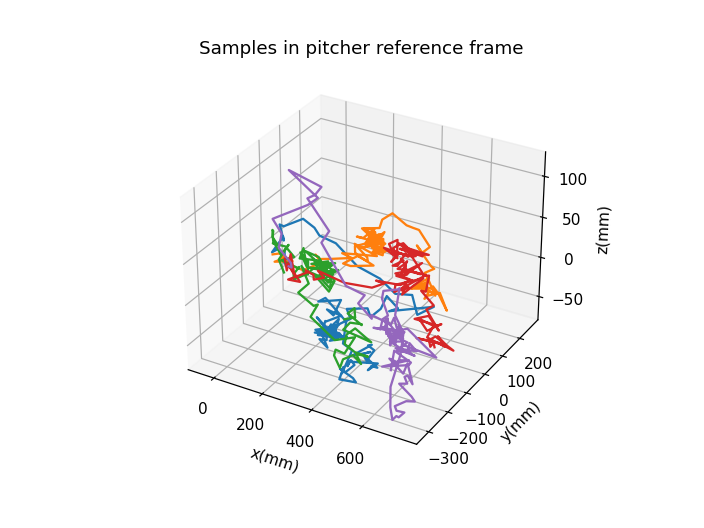

In [298]:
#4) Plot some samples from the learned ProMP and conditioned ProMP

n_samples = 5 # Number of samples to draw
plot_dof = 1 # Degree of freedom to plot
sample_time = [np.linspace(0,1,100) for i in range(n_samples)]

#4.1) Make some samples from the unconditioned ProMP
individual = 'pitcher'
promp_samples = promps[individual].sample(sample_time)
plt.figure()
ax = plt.axes(projection='3d')
for t,q in zip(sample_time, promp_samples):
    if q.shape[1] == 1:
        plt.plot(np.array(t) - t[0],q[:,0])
    else:
        ax.plot(q[:,2], q[:,1], - q[:,0])
        ax.set_xlabel('x(mm)')
        ax.set_ylabel('y(mm)')
        ax.set_zlabel('z(mm)')
        ax.set_title(f'Samples in {individual} reference frame')
plt.show()

<IPython.core.display.Javascript object>


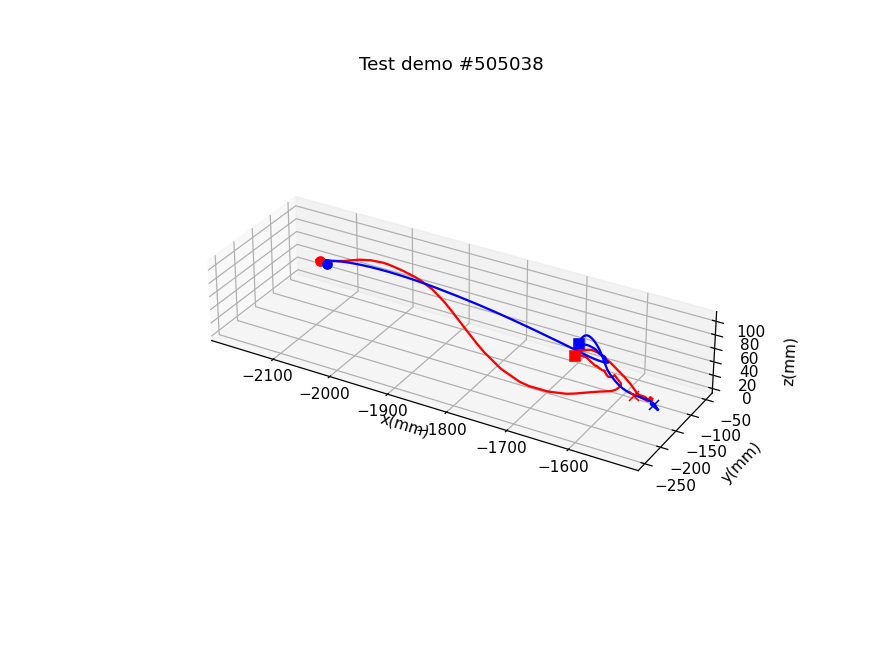

This distance at the start point is 11.721110971146288 mm
This distance at the middle point is 18.56330877981837 mm
This distance at the end point is 39.97253956264768 mm


<IPython.core.display.Javascript object>


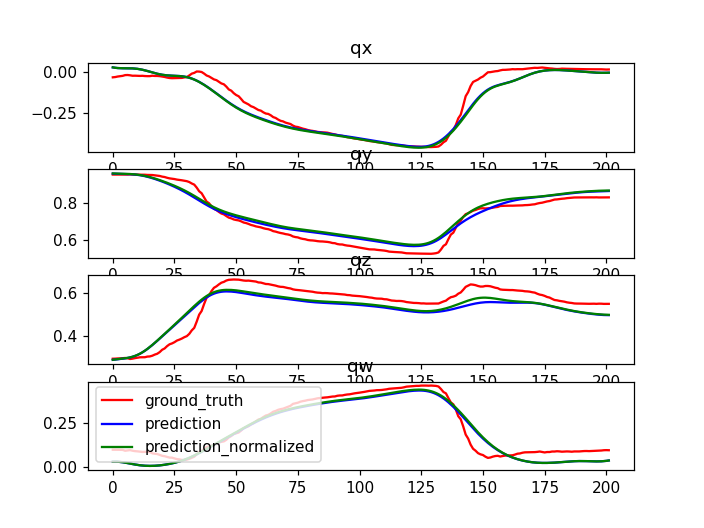

In [299]:
def get_mean_cov_hats(ref_means, ref_covs, min_len=None):
    sigma_hats, ref_pts = [], len(ref_means)
    if not min_len:
        min_len = min([len(r) for r in ref_means])
    # solve for global covariance
    for p in range(min_len):
        covs = [cov[p] for cov in ref_covs]
        inv_sum = np.linalg.inv(covs[0])
        for ref in range(1, ref_pts):
            inv_sum = inv_sum + np.linalg.inv(covs[ref])
        sigma_hat = np.linalg.inv(inv_sum)
        sigma_hats.append(sigma_hat)

    mean_hats = []
    for p in range(min_len):
        mean_w_sum = np.matmul(np.linalg.inv(ref_covs[0][p]), ref_means[0][p])
        for ref in range(1, ref_pts):
            mean_w_sum = mean_w_sum + np.matmul(np.linalg.inv(ref_covs[ref][p]), ref_means[ref][p])
        mean_hats.append(np.matmul(sigma_hats[p], mean_w_sum))
    return np.array(mean_hats), np.array(sigma_hats)

test_demos = [demo for demo in demos if demo not in train_demos and demo not in bad_demos]
individuals = ['pitcher', 'teabag1', 'cup', 'tap', 'teabag2']
# individuals = ['tap', 'teabag1', 'cup']
for demo in test_demos:
    ground_truth = gripper_trajs_in_ndi[demo][['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']].to_numpy()
    t = np.linspace(0,1, ground_truth.shape[0])

    means_objs_global = []
    covs_objs_global = []
    for individual in individuals:
        mean, cov = promps[individual].marginal_w(t)
        if dof == 3:
            translation = obj_pos_in_ndi[demo][individual]
        elif dof == 7:
            translation = np.zeros(dof)
            translation[:3] = obj_pos_in_ndi[demo][individual]
        mean_global = mean + translation
        means_objs_global.append(mean_global)
        covs_objs_global.append(np.array(cov))
    mean_hats, sigma_hats = get_mean_cov_hats(means_objs_global, covs_objs_global)
    mid_ind = int(0.62 * len(mean_hats))
    
    plt.figure(figsize = (8,6))
    ax = plt.axes(projection='3d')
    ax.plot(ground_truth[:,2], ground_truth[:,1], -ground_truth[:,0],'r', label = 'ground_truth')
    ax.plot(mean_hats[:,2], mean_hats[:,1], -mean_hats[:,0], 'b', label = 'prediction')
    ax.plot(ground_truth[0,2], ground_truth[0,1], -ground_truth[0,0],'ro', label = 'start')
    ax.plot(ground_truth[mid_ind,2], ground_truth[mid_ind,1], -ground_truth[mid_ind,0],'rs', label = 'middle')
    ax.plot(ground_truth[-1,2], ground_truth[-1,1], -ground_truth[-1,0],'rx', label = 'end')
    ax.plot(mean_hats[0,2], mean_hats[0,1], -mean_hats[0,0],'bo', label = 'start')
    ax.plot(mean_hats[mid_ind,2], mean_hats[mid_ind,1], -mean_hats[mid_ind,0],'bs', label = 'middle')
    ax.plot(mean_hats[-1,2], mean_hats[-1,1], -mean_hats[-1,0],'bx', label = 'end')
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
#     ax.set_aspect('equal')
    ax.set_box_aspect((np.ptp(ground_truth[:,2]), np.ptp(ground_truth[:,1]), np.ptp(-ground_truth[:,0])))
    ax.set_title(f'Test demo #{demo}')
    dist_mid = np.linalg.norm(ground_truth[mid_ind,:3] - mean_hats[mid_ind,:3])
    dist_start = np.linalg.norm(ground_truth[0,:3] - mean_hats[0,:3])
    dist_end = np.linalg.norm(ground_truth[-1,:3] - mean_hats[-1,:3])
    print(f'This distance at the start point is {dist_start} mm')
    print(f'This distance at the middle point is {dist_mid} mm')
    print(f'This distance at the end point is {dist_end} mm')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
    ax1.plot(ground_truth[:,3],'r', label = 'ground_truth')
    ax1.plot(mean_hats[:,3],'b', label = 'prediction')
    ax1.set_title('qx')
    ax2.plot(ground_truth[:,4],'r', label = 'ground_truth')
    ax2.plot(mean_hats[:,4],'b', label = 'prediction')
    ax2.set_title('qy')
    ax3.plot(ground_truth[:,5],'r', label = 'ground_truth')
    ax3.plot(mean_hats[:,5],'b', label = 'prediction')
    ax3.set_title('qz')
    ax4.plot(ground_truth[:,6],'r', label = 'ground_truth')
    ax4.plot(mean_hats[:,6],'b', label = 'prediction')
    ax4.set_title('qw')
    
    from sklearn.preprocessing import normalize
    mean_hats_normalized = normalize(mean_hats[:,3:], axis = 1)
    ax1.plot(mean_hats_normalized[:,0],'g', label = 'prediction_normalized')
    ax1.set_title('qx')
    ax2.plot(mean_hats_normalized[:,1],'g', label = 'prediction_normalized')
    ax2.set_title('qy')
    ax3.plot(mean_hats_normalized[:,2],'g', label = 'prediction_normalized')
    ax3.set_title('qz')
    ax4.plot(mean_hats_normalized[:,3],'g', label = 'prediction_normalized')
    ax4.set_title('qw')
    plt.legend() 
    plt.legend()
#     plt.show()


In [ ]:
505038
636939
297761
435030
505039
636940
463674

['teabag1', 'teabag2', 'pitcher', 'cup', 'tap']: [24.97148048 28.07291676 87.67699545]
[[ 11.0317731   20.49365617  40.07441764]
 [ 24.21302402  13.91717303  43.16869166]
 [ 33.48251514  39.52509641 185.21746825]
 [ 34.91819283  15.58028429 130.69624834]
 [ 21.72931897  36.57425214  77.22796831]
 [ 26.5144254   11.66225198  73.67897457]
 [ 22.91111389  58.75770332  63.67519934]]

['tap', 'teabag1', 'cup', 'pitcher']: [23.7454193  28.11763542 80.88095542]
[[ 11.53759471  22.81356364  43.10968073]
 [ 24.0232561   16.11402198  38.66260021]
 [ 34.08564552  39.87460383 186.65987583]
 [ 26.40651405  11.02318228  94.41918271]
 [ 22.21000281  37.41287898  67.95415736]
 [ 25.81379402  11.49462374  76.37197029]
 [ 22.14112786  58.09057348  58.98922077]]  

['tap', 'teabag1', 'cup']: [25.78699158 27.82609236 78.42271145]
[[ 24.93990775  23.92085379  51.47702739]
 [ 14.74528151  17.64365966  29.14321961]
 [ 53.1480962   38.55846114 192.28424333]
 [ 25.68753915  11.31759282  90.8568821 ]
 [ 25.49801611  36.27769275  45.2376616 ]
 [ 26.49684771   8.95400816  94.58563233]
 [  9.99325262  58.11037819  45.37431374]]

['tap', 'teabag1']: [24.86218814 28.93454261 82.55835976]
[[ 24.78859262  13.40400392  46.73301209]
 [ 15.17725077  20.3760296   34.57467149]
 [ 42.47525902  42.00533856 189.40095342]
 [ 25.96280149  13.45009394  96.87085417]
 [ 28.48706956  32.75379452  66.61138761]
 [ 26.33239604  15.40678486  76.86680851]
 [ 10.81194745  65.14575289  66.850831  ]]

['pitcher', 'teabag1']: [25.7545654  28.67852391 81.550214  ]
[[ 11.84259045  13.16130431  43.51117469]
 [ 39.78821481  18.38089495  39.41511514]
 [ 25.71437622  41.28062837 189.43238587]
 [ 27.81485952  12.14403387  97.34888046]
 [ 13.20717054  35.60124613  56.58474375]
 [ 27.0312622   15.00705932  74.37216244]
 [ 34.88348402  65.17450041  70.18703565]]

<IPython.core.display.Javascript object>


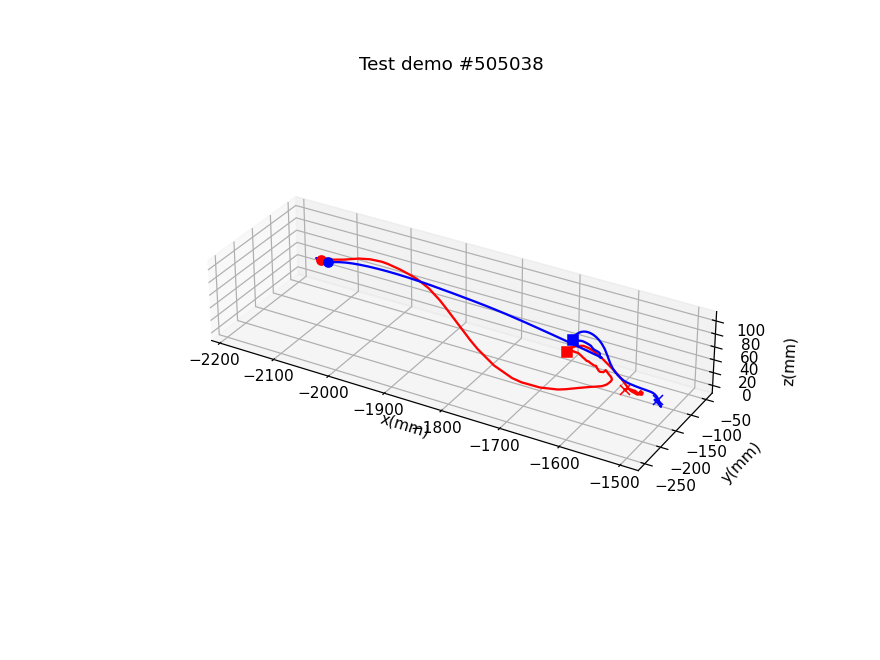

This distance at the start point is 11.490079239018783 mm
This distance at the middle point is 20.180503604671213 mm
This distance at the end point is 55.23810303946889 mm


<IPython.core.display.Javascript object>


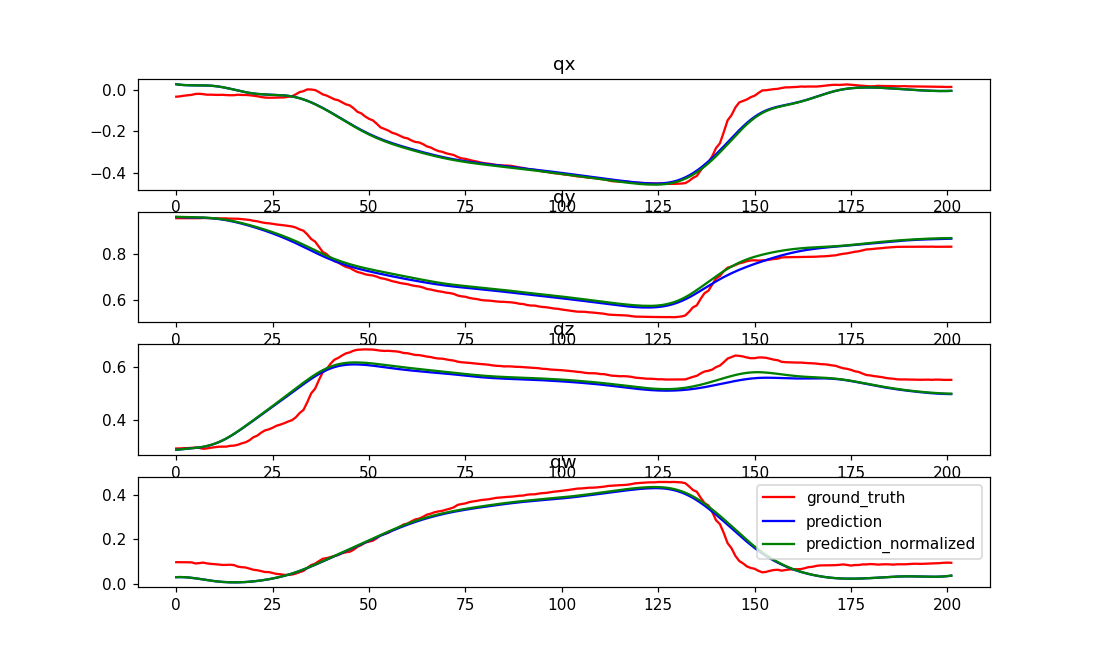

In [303]:
individuals =  ['pitcher', 'teabag1', 'cup', 'tap', 'teabag2']

for demo in test_demos:
    ground_truth = gripper_trajs_in_ndi[demo][['x', 'y', 'z', 'qx', 'qy', 'qz', 'qw']].to_numpy()
    t = np.linspace(0,1, ground_truth.shape[0])

    means_objs_global = []
    covs_objs_global = []
    for individual in individuals:
        mean, cov = promps[individual].marginal_w(t)
        if dof == 3:
            translation = obj_pos_in_ndi[demo][individual]
        elif dof == 7:
            translation = np.zeros(dof)
            translation[:3] = obj_pos_in_ndi[demo][individual]
        mean_global = mean + translation
        means_objs_global.append(mean_global)
        covs_objs_global.append(np.array(cov) * np.array(cov))
    n_individuals = len(individuals)
    relavent_inds = []
    covs_objs_global = np.array(covs_objs_global)
    for j in range(len(t)):
        for k in range(7):
            variances = covs_objs_global[:,j,k,k]
            median = np.median(variances)
            minimum = np.min(variances)
            for i, v in enumerate(variances):
                if v > median:
                    variances[i] = v

    mean_hats, sigma_hats = get_mean_cov_hats(means_objs_global, covs_objs_global)
    mid_ind = int(0.62 * len(mean_hats))
    
    plt.figure(figsize = (8,6))
    ax = plt.axes(projection='3d')
    ax.plot(ground_truth[:,2], ground_truth[:,1], -ground_truth[:,0],'r', label = 'ground_truth')
    ax.plot(mean_hats[:,2], mean_hats[:,1], -mean_hats[:,0], 'b', label = 'prediction')
    ax.plot(ground_truth[0,2], ground_truth[0,1], -ground_truth[0,0],'ro', label = 'start')
    ax.plot(ground_truth[mid_ind,2], ground_truth[mid_ind,1], -ground_truth[mid_ind,0],'rs', label = 'middle')
    ax.plot(ground_truth[-1,2], ground_truth[-1,1], -ground_truth[-1,0],'rx', label = 'end')
    ax.plot(mean_hats[0,2], mean_hats[0,1], -mean_hats[0,0],'bo', label = 'start')
    ax.plot(mean_hats[mid_ind,2], mean_hats[mid_ind,1], -mean_hats[mid_ind,0],'bs', label = 'middle')
    ax.plot(mean_hats[-1,2], mean_hats[-1,1], -mean_hats[-1,0],'bx', label = 'end')
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
#     ax.set_aspect('equal')
    ax.set_box_aspect((np.ptp(ground_truth[:,2]), np.ptp(ground_truth[:,1]), np.ptp(-ground_truth[:,0])))
    ax.set_title(f'Test demo #{demo}')
    dist_mid = np.linalg.norm(ground_truth[mid_ind,:3] - mean_hats[mid_ind,:3])
    dist_start = np.linalg.norm(ground_truth[0,:3] - mean_hats[0,:3])
    dist_end = np.linalg.norm(ground_truth[-1,:3] - mean_hats[-1,:3])
    print(f'This distance at the start point is {dist_start} mm')
    print(f'This distance at the middle point is {dist_mid} mm')
    print(f'This distance at the end point is {dist_end} mm')
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize = (10,6))
    ax1.plot(ground_truth[:,3],'r', label = 'ground_truth')
    ax1.plot(mean_hats[:,3],'b', label = 'prediction')
    ax1.set_title('qx')
    ax2.plot(ground_truth[:,4],'r', label = 'ground_truth')
    ax2.plot(mean_hats[:,4],'b', label = 'prediction')
    ax2.set_title('qy')
    ax3.plot(ground_truth[:,5],'r', label = 'ground_truth')
    ax3.plot(mean_hats[:,5],'b', label = 'prediction')
    ax3.set_title('qz')
    ax4.plot(ground_truth[:,6],'r', label = 'ground_truth')
    ax4.plot(mean_hats[:,6],'b', label = 'prediction')
    ax4.set_title('qw')
    
    from sklearn.preprocessing import normalize
    mean_hats_normalized = normalize(mean_hats[:,3:], axis = 1)
    ax1.plot(mean_hats_normalized[:,0],'g', label = 'prediction_normalized')
    ax1.set_title('qx')
    ax2.plot(mean_hats_normalized[:,1],'g', label = 'prediction_normalized')
    ax2.set_title('qy')
    ax3.plot(mean_hats_normalized[:,2],'g', label = 'prediction_normalized')
    ax3.set_title('qz')
    ax4.plot(mean_hats_normalized[:,3],'g', label = 'prediction_normalized')
    ax4.set_title('qw')
    plt.legend()    
        

In [ ]:
[24.49927774 28.09432845 80.87035896]

In [ ]:
# original
[25.46011333 27.96479883 87.65244728]
[[ 13.74002059  20.29116191  40.13161539]
 [ 24.81560273  13.45138256  43.17173106]
 [ 33.08494114  39.13947139 185.19980543]
 [ 34.18520286  15.68449878 130.50692313]
 [ 24.29820942  36.77611411  77.18486148]
 [ 25.0775565   11.70422326  73.68955742]
 [ 23.01926006  58.7067398   63.68263704]]

In [ ]:
# median
[25.24222023 25.93246008 81.77943363]
[[ 14.00635696  19.60853301  51.70137324]
 [ 24.90398109  14.41604074  31.02685386]
 [ 28.35771376  36.77436475 191.92337433]
 [ 35.51057197   9.13766589 111.60778437]
 [ 26.28696616  34.33173876  46.05699064]
 [ 24.63111159   7.84471115  94.4678179 ]
 [ 22.9988401   59.41416624  45.67184104]]

In [ ]:
# cov * cov
[24.06930009 25.76908122 82.82235135]
[[ 14.82657324  22.22619652  55.40068104]
 [ 25.61418468  14.97557727  30.01226559]
 [ 24.88514714  34.23065304 194.86859214]
 [ 27.193155     5.64061197 103.72459001]
 [ 29.30477674  35.50225336  47.87208134]
 [ 24.40034908   5.66458683 103.46180407]
 [ 22.26091472  62.14368953  44.41644524]]

# Run many tests and see the average result

In [96]:
n_test = 7
# bad_demos = []
# bad_demos = ['463678', '636936'] # demos with mislabeld teabag1
# bad_demos = ['636938', '463675'] # demos that starts late
bad_demos = ['463678', '636936', '636938', '463675']
dists = []
for i in range(n_test):
    sig = 0.035 # The standard deviation of the Gaussian functions
    # Define the basis functions
    full_basis = {
            'conf': [
                    {"type": "sqexp", "nparams": 22, "conf": {"dim": 21}},
                {"type": "poly", "nparams": 0, "conf": {"order": 1}},
                {"type": "poly", "nparams": 0, "conf": {"order": 2}},
                {"type": "poly", "nparams": 0, "conf": {"order": 3}}
                ],
            'params': [np.log(sig),0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65
                       ,0.7,0.75,0.8,0.85,0.9,0.95,1]
            }

    individuals = ['pitcher', 'teabag1', 'cup', 'tap', 'teabag2']
    # Each individual will have its own promp model
    promps = {individual : promp.FullProMP(basis=full_basis) for individual in individuals}


    #3) Train ProMP with NIW prior on the covariance matrix (as described in the paper)

    gripper_trajs_in_obj_filtered_train = {individual: {'coords':[], 'time':[]} for individual in individuals}
    demos = [demo for demo in list(gripper_trajs_in_ndi.keys())if demo not in bad_demos]
    train_demos = random.sample(demos, k=6)
    test_demos = [demo for demo in demos if demo not in train_demos and demo not in bad_demos]

    for individual in individuals:
        for d in train_demos:
            t = gripper_trajs_in_obj_filtered[individual][d]['Time'].to_numpy().flatten()
            t = t / t[-1]
            gripper_trajs_in_obj_filtered_train[individual]['coords'].append(
                gripper_trajs_in_obj_filtered[individual][d].loc[:,['x', 'y','z', 'Rx', 'Ry', 'Rz']].to_numpy())
            gripper_trajs_in_obj_filtered_train[individual]['time'].append(t)

    dof = 6
    dim_basis_fun = 30
    inv_whis_mean = lambda v, Sigma: 9e-1*utils.make_block_diag(Sigma, dof) + 1e-1*np.eye(dof*dim_basis_fun)
    prior_Sigma_w = {'v':dim_basis_fun*dof, 'mean_cov_mle': inv_whis_mean}
    for individual in individuals:
        Q = gripper_trajs_in_obj_filtered_train[individual]['coords']
        times = gripper_trajs_in_obj_filtered_train[individual]['time']
        train_summary = promps[individual].train(times, q = Q, max_iter=30, prior_Sigma_w=prior_Sigma_w,
                print_inner_lb=True)

    demo = random.choice(test_demos)
    ground_truth = gripper_trajs_in_ndi[demo][['x', 'y', 'z', 'Rx', 'Ry', 'Rz']].to_numpy()
    t = np.linspace(0,1, ground_truth.shape[0])

    means_objs_global = []
    covs_objs_global = []
    for individual in individuals:
        mean, cov = promps[individual].marginal_w(t)
        if dof == 3:
            translation = obj_pos_in_ndi[demo][individual]
        elif dof == 6:
            translation = np.zeros(dof)
            translation[:3] = obj_pos_in_ndi[demo][individual]
        mean_global = mean + translation

        means_objs_global.append(mean_global)
        covs_objs_global.append(cov)

    mean_hats, sigma_hats = get_mean_cov_hats(means_objs_global, covs_objs_global)
    mid_ind = int(0.62 * len(mean_hats))
    dist_mid = np.linalg.norm(ground_truth[mid_ind,:3] - mean_hats[mid_ind,:3])
    dist_start = np.linalg.norm(ground_truth[0,:3] - mean_hats[0,:3])
    dist_end = np.linalg.norm(ground_truth[-1,:3] - mean_hats[-1,:3])
    dists.append([dist_start, dist_mid, dist_end])

lb(mu_w)= -8738032.287001204
lb(Sigma_w)= -87648.96272147432
lb(Sigma_y)= -36705.36602303273
lb(mu_w)= -37181.36626979725
lb(Sigma_w)= -33004.75687713551
lb(Sigma_y)= -32052.868143573967
lb(mu_w)= -33123.30267570625
lb(Sigma_w)= -30624.13256351415
lb(Sigma_y)= -30169.71714187861
lb(mu_w)= -31685.67504407488
lb(Sigma_w)= -29833.438042094087
lb(Sigma_y)= -29771.1729377226
lb(mu_w)= -31320.03687514991
lb(Sigma_w)= -29790.97630707482
lb(Sigma_y)= -29786.9354109619
lb(mu_w)= -31186.44687911932
lb(Sigma_w)= -29825.847348609153
lb(Sigma_y)= -29824.025516428163
lb(mu_w)= -31081.683176737733
lb(Sigma_w)= -29835.13249332675
lb(Sigma_y)= -29833.782837307055
lb(mu_w)= -30977.109033827357
lb(Sigma_w)= -29824.803654760035
lb(Sigma_y)= -29823.74756294004
lb(mu_w)= -30870.74580040631
lb(Sigma_w)= -29804.11436771454
lb(Sigma_y)= -29803.26846365595
lb(mu_w)= -30765.103498580276
lb(Sigma_w)= -29779.203829751303
lb(Sigma_y)= -29778.518188626735
lb(mu_w)= -30662.932503396976
lb(Sigma_w)= -29753.77318894729

lb(Sigma_y)= -29712.697541985413
lb(mu_w)= -29907.189234469286
lb(Sigma_w)= -29723.0131146145
lb(Sigma_y)= -29722.992958486753
lb(mu_w)= -29905.825502642154
lb(Sigma_w)= -29733.941424768287
lb(Sigma_y)= -29733.923891540424
lb(mu_w)= -8696822.961065043
lb(Sigma_w)= -87783.0309183288
lb(Sigma_y)= -36766.127001653396
lb(mu_w)= -37231.60139077163
lb(Sigma_w)= -33118.28811924277
lb(Sigma_y)= -32153.375852626577
lb(mu_w)= -33104.722179868986
lb(Sigma_w)= -30696.59531263058
lb(Sigma_y)= -30241.83214418939
lb(mu_w)= -31672.304371903047
lb(Sigma_w)= -29888.03256537044
lb(Sigma_y)= -29826.070767739802
lb(mu_w)= -31331.400570657082
lb(Sigma_w)= -29838.48409189259
lb(Sigma_y)= -29834.712599155522
lb(mu_w)= -31212.151928623203
lb(Sigma_w)= -29871.665421012694
lb(Sigma_y)= -29870.021141122852
lb(mu_w)= -31112.14601946299
lb(Sigma_w)= -29881.6229893882
lb(Sigma_y)= -29880.393287288196
lb(mu_w)= -31007.939846015877
lb(Sigma_w)= -29872.932815679607
lb(Sigma_y)= -29871.96434201337
lb(mu_w)= -30900.76677

RuntimeError: No active exception to reraise

In [95]:
ground_truth.shape

(201, 3)

<IPython.core.display.Javascript object>


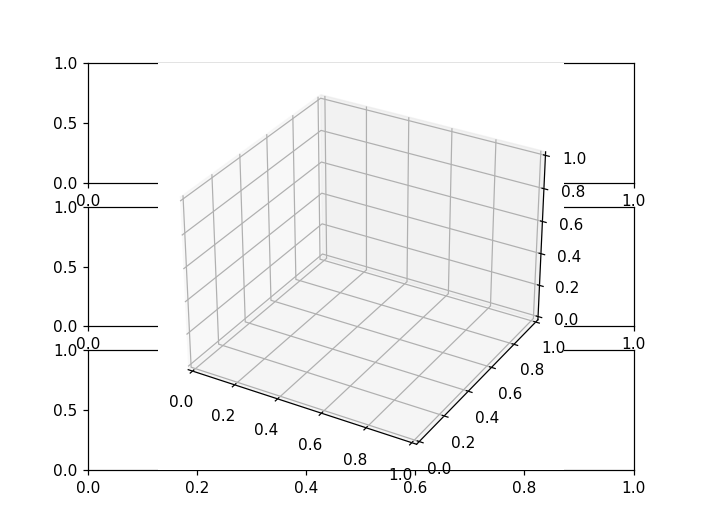

IndexError: index 3 is out of bounds for axis 1 with size 3

In [94]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)
ax = plt.axes(projection='3d')
ax1.plot(ground_truth[:,3],'r', label = 'ground_truth')
ax1.plot(mean_hats[:,3],'b', label = 'prediction')
# ax.plot(mean_hats[:,2], mean_hats[:,1], -mean_hats[:,0], 'b', label = 'prediction')
# ax.plot(ground_truth[0,2], ground_truth[0,1], -ground_truth[0,0],'ro', label = 'start')
# ax.plot(ground_truth[mid_ind,2], ground_truth[mid_ind,1], -ground_truth[mid_ind,0],'rs', label = 'middle')
# ax.plot(ground_truth[-1,2], ground_truth[-1,1], -ground_truth[-1,0],'rx', label = 'end')
# ax.plot(mean_hats[0,2], mean_hats[0,1], -mean_hats[0,0],'bo', label = 'start')
# ax.plot(mean_hats[mid_ind,2], mean_hats[mid_ind,1], -mean_hats[mid_ind,0],'bs', label = 'middle')
# ax.plot(mean_hats[-1,2], mean_hats[-1,1], -mean_hats[-1,0],'bx', label = 'end')
# ax.set_xlabel('x(mm)')
# ax.set_ylabel('y(mm)')
# ax.set_zlabel('z(mm)')

In [ ]:
[25.78699158 27.82609236 78.42271145]
[23.7454193  28.11763542 80.88095542]
[24.97148048 28.07291676 87.67699545]

In [ ]:
# All demos(11)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

In [ ]:
# 9 demos(mislabeled teabag1 demos(2) are not used)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

In [ ]:
# 9 demos(demos that starts late(2) are not used)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

In [ ]:
# 7 demos(mislabeled teabag1 demos(2) and demos that started late are not used)
dists = np.array(dists)
print(np.mean(dists, axis = 0))

In [91]:
# 7 demos(mislabeled teabag1 demos(2) and demos that started late are not used) with global reference frame trajs
dists = np.array(dists)
print(np.mean(dists, axis = 0))

[ 32.78633855  23.63227878 105.9529457 ]


In [ ]:
# import pickle
# from itertools import combinations

# def homogenous_transform(R,vect):

#     '''
#     :param R: 3x3 matrix
#     :param vect: list x,y,z
#     :return:Homogenous transformation 4x4 matrix using R and vect
#     '''

#     H = np.zeros((4,4))
#     H[0:3,0:3] = R
#     frame_displacement = vect + [1]
#     D = np.array(frame_displacement)
#     D.shape = (1,4)
#     H[:,3] = D
#     return H

# def inverse_homogenous_transform(H):

#     '''
#     :param H: Homogenous Transform Matrix
#     :return: Inverse Homegenous Transform Matrix
#     '''


#     R = H[0:3,0:3]
#     origin = H[:-1,3]
#     origin.shape = (3,1)

#     R = R.T
#     origin = -R.dot(origin)
#     return homogenous_transform(R,list(origin.flatten()))

# def rigid_transform_3D(A, B):
#     assert A.shape == B.shape

#     num_rows, num_cols = A.shape
#     if num_rows != 3:
#         raise Exception(f"matrix A is not 3xN, it is {num_rows}x{num_cols}")

#     num_rows, num_cols = B.shape
#     if num_rows != 3:
#         raise Exception(f"matrix B is not 3xN, it is {num_rows}x{num_cols}")

#     # find mean column wise
#     centroid_A = np.mean(A, axis=1)
#     centroid_B = np.mean(B, axis=1)

#     # ensure centroids are 3x1
#     centroid_A = centroid_A.reshape(-1, 1)
#     centroid_B = centroid_B.reshape(-1, 1)

#     # subtract mean
#     Am = A - centroid_A
#     Bm = B - centroid_B

#     H = Am @ np.transpose(Bm)

#     # sanity check
#     #if linalg.matrix_rank(H) < 3:
#     #    raise ValueError("rank of H = {}, expecting 3".format(linalg.matrix_rank(H)))

#     # find rotation
#     U, S, Vt = np.linalg.svd(H)
#     R = Vt.T @ U.T

# #     special reflection case
#     if np.linalg.det(R) < 0:
# #         print("det(R) < R, reflection detected!, correcting for it ...")
#         Vt[2,:] *= -1
#         R = Vt.T @ U.T

#     t = -R @ centroid_A + centroid_B

#     return R, t

# def get_HT_template_in_obj(template, obj_coord, camera_in_template):
#     idx = pd.IndexSlice
#     points_template = []
#     points_obj = []
#     if not isinstance(obj_coord, dict):
#         bps = obj_coord.index.get_level_values('bodyparts').unique()
#         for bodypart in bps:
#             df_bodypart = obj_coord.loc[bodypart]
#             if not df_bodypart.isnull().values.any():
#                 points_template.append(template[bodypart])
#                 points_obj.append(df_bodypart.to_numpy())
#     else:
#         keys = obj_coord.keys()
#         for bodypart in keys:
#             df_bodypart = df[bodypart]
#             if not df_bodypart.isnull().values.any():
#                 points_template.append(template[bodypart])
#                 points_obj.append(df_bodypart.to_numpy())
                
#     points_template = np.array(points_template).T
#     points_obj = np.array(points_obj).T
    
#     points_template_in_template = camera_in_template @ homogenous_position(points_template)
#     points_obj_in_template = camera_in_template @ homogenous_position(points_obj)
#     rotmatrix, translation = rigid_transform_3D(points_obj_in_template[:3,:], points_template_in_template[:3,:])
#     H = homogenous_transform(rotmatrix, list(translation.flatten()))
    
#     points_obj_transformed = (H @ points_obj_in_template).T
#     dists = []
#     for i, point in enumerate(points_obj_transformed):
#         point = point[:3]
#         dist = np.linalg.norm(point[:3] - points_template_in_template[:-1,i])
#         dists.append(dist)
#     dist_average = np.mean(np.array(dists), axis=0)
# #     print(f'distances : {dists}')
# #     print(f'average distance: {dist_average}')
#     return H, dist_average


# def homogenous_position(vect):
#     temp = np.array(vect)
#     if temp.ndim == 1:
#         ones = np.ones(1)
#         return np.r_[temp, ones].reshape(-1, 1)
#     elif temp.ndim == 2:
        
#         num_rows, num_cols = temp.shape
#         if num_rows != 3:
#             raise Exception(f"vect is not 3 * N, it is {num_rows}x{num_cols}")

#         ones = np.ones(num_cols).reshape(1,-1)
#         return np.r_[temp, ones]

# def get_obj_coord_median(df_individual, window_size = 10):
#     bps = df_individual.columns.get_level_values('bodyparts').unique()
#     obj_coord = {}
#     for bp in bps:
#         obj_coord[bp] = df_individual[bp].iloc[:window_size].median()
#     return obj_coord


# template_dir = f'/home/luke/Desktop/project/make_tea/Process_data/postprocessed/2022-05-26/transformations/{triangulation}'

# with open(os.path.join(template_dir, 'obj_templates.pickle'), "rb") as f:
#     obj_templates = pickle.load(f)

# with open(os.path.join(template_dir, 'camera_to_ndi.pickle'), "rb") as f:
#     camera_in_ndi = pickle.load(f)
    
# with open(os.path.join(template_dir, 'ndi_to_camera.pickle'), "rb") as f:
#     ndi_in_camera = pickle.load(f)

# individual = 'tap'
# if 'teabag' in individual:
#     obj = 'teabag'
# else:
#     obj = individual

# obj_template = obj_templates[obj]
# rot_matrix = ndi_in_camera[:3,:3]


# markers = []
# for bp in obj_template:
#     markers.append(obj_template[bp])
# markers = np.array(markers)
# center = np.mean(markers, axis=0)
# template_in_camera = homogenous_transform(rot_matrix, list(center))
# camera_in_template = inverse_homogenous_transform(template_in_camera)

# fig,ax = plt.subplots(1,1, figsize = (10,8))
# ax = plt.axes(projection='3d')
# idx = pd.IndexSlice
# bad_demos = ['463678', '636936', '636938', '463675']
# '''
# '463678', '636936': mislabeled teabag1
# '636938', '463675': starting point far from other demos
# '''

# window_size = 20
# n_marker = 3
# dists = {}

# for demo in obj_trajs_in_camera:
#     dist = np.inf
#     for i in range(window_size):
#         marker_coords = obj_trajs_in_camera_full[demo][individual].iloc[i]
#         bps = marker_coords.index.get_level_values('bodyparts').unique()
#         combs = combinations(bps, n_marker)
#         for comb in combs:
#             partial_marker_coords = marker_coords.loc[list(comb)]
#             if partial_marker_coords.isnull().any():
#                 continue
#             H, dist_average = get_HT_template_in_obj(obj_template, partial_marker_coords, camera_in_template)
#             if dist_average < dist:
#                 dist = dist_average
#                 template_in_obj = H
                
#     dists[demo] = dist
#     if dist > 20:
#         bad_demos.append(demo)
#     if demo in bad_demos:
#         continue
#     gripper_traj = gripper_trajs_in_ndi[demo].loc[:,['x', 'y', 'z']].to_numpy()
#     obj_in_template = inverse_homogenous_transform(template_in_obj)
#     obj_in_camera = template_in_camera @ obj_in_template
#     obj_in_ndi = camera_in_ndi @ obj_in_camera
#     obj_in_ndi[:3, :3] = np.eye(3)
#     ndi_in_obj = inverse_homogenous_transform(obj_in_ndi)
# #     gripper_in_obj = gripper_traj - obj_in_ndi[:-1,3]
#     gripper_in_obj = (ndi_in_obj @ homogenous_position(gripper_traj.T)).T
    
#     ax.plot(gripper_in_obj[:, 0], gripper_in_obj[:, 1], gripper_in_obj[:, 2], label = f'{demo}')
#     ax.plot(gripper_in_obj[0, 0], gripper_in_obj[0, 1], gripper_in_obj[0, 2], 'o')
#     ax.plot(gripper_in_obj[-1, 0], gripper_in_obj[-1, 1], gripper_in_obj[-1, 2], 'x')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# ax.legend()